In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import requests
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [8]:
etf_symbols = ['XLI']

start_date = '1900-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

def get_etf_data(etf_symbol):
    etf = yf.download(etf_symbol, start=start_date, end=end_date)
    return etf

etf_data = pd.DataFrame()

for symbol in etf_symbols:
    etf = get_etf_data(symbol)
    etf_data[symbol] = etf['Close']

etf_data = etf_data.astype(float)
etf_data.reset_index(inplace=True)
etf_data['Date'] = pd.to_datetime(etf_data['Date'])
etf_data['Quarter'] = etf_data['Date'].dt.to_period('M')
etf_data = etf_data.groupby('Quarter').mean().reset_index()
premiere_dates_trimestre = etf_data.groupby('Quarter')['Date'].first().reset_index()
etf_data['Date'] = premiere_dates_trimestre['Date']
etf_data = etf_data.reindex(columns=['Date', 'XLI'])
etf_data['Date'] = etf_data['Date'].dt.strftime('%Y-%m')

etf_data

[*********************100%***********************]  1 of 1 completed


,Date,XLI
0,1998-12,15.013719
1,1999-01,15.197803
2,1999-02,15.269106
3,1999-03,15.632314
4,1999-04,17.146041
...,...,...
318,2025-06,143.187578
319,2025-07,150.464274
320,2025-08,150.863383
321,2025-09,151.514410


In [10]:
api_key = "8e877013bcb3862ac90cd864024bdb75"

def download_fred_data(series_id, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&observation_start={start_date}&observation_end={end_date}&file_type=json"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['observations'])
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.rename(columns={'value': series_id}, inplace=True)
    return df

retail_sales_data = download_fred_data("RSXFS", "1900-01-01", "2024-12-31")
retail_sales_data['RSXFS'] = pd.to_numeric(retail_sales_data['RSXFS'], errors='coerce')

retail_sales_data.reset_index(inplace=True)
retail_sales_data['Date'] = retail_sales_data['date'].dt.strftime('%Y-%m')
retail_sales_data.drop(columns=['date'], inplace=True)
retail_sales_data = retail_sales_data[['RSXFS', 'Date']]

gdp_data = download_fred_data("GDP", "1900-01-01", "2024-12-31")
inflation_data = download_fred_data("CPIAUCNS", "1900-01-01", "2024-12-31")

gdp_data['GDP'] = pd.to_numeric(gdp_data['GDP'], errors='coerce')
inflation_data['CPIAUCNS'] = pd.to_numeric(inflation_data['CPIAUCNS'], errors='coerce')

gdp_data.index = pd.to_datetime(gdp_data.index)
gdp_data = gdp_data.asfreq('M', method='ffill')
gdp_data.reset_index(inplace=True)
gdp_data['Date'] = gdp_data['date'].dt.strftime('%Y-%m')
gdp_data.drop(columns=['date'], inplace=True)
gdp_data = gdp_data[['GDP', 'Date']]

inflation_data.reset_index(inplace=True)
inflation_data['Date'] = inflation_data['date'].dt.strftime('%Y-%m')
inflation_data.drop(columns=['date'], inplace=True)
inflation_data = inflation_data[['CPIAUCNS', 'Date']]

datasets = [
    "retail_sales_data",
    "etf_data",
    "gdp_data",
    "inflation_data",]

pmi_data = globals()[datasets[0]]
for data_name in datasets[1:]:
    data = globals()[data_name]
    pmi_data = pd.merge(pmi_data, data, on='Date')

pmi_data

,RSXFS,Date,XLI,GDP,CPIAUCNS
0,217396.0,1998-12,15.013719,9293.991,163.900
1,217930.0,1999-01,15.197803,9411.682,164.300
2,220769.0,1999-02,15.269106,9411.682,164.500
3,222199.0,1999-03,15.632314,9411.682,165.000
4,223837.0,1999-04,17.146041,9526.210,166.200
...,...,...,...,...,...
305,600372.0,2024-05,121.428544,29147.044,314.069
306,599979.0,2024-06,119.817705,29147.044,314.175
307,605814.0,2024-07,121.941630,29511.664,314.540
308,603719.0,2024-08,123.989325,29511.664,314.796


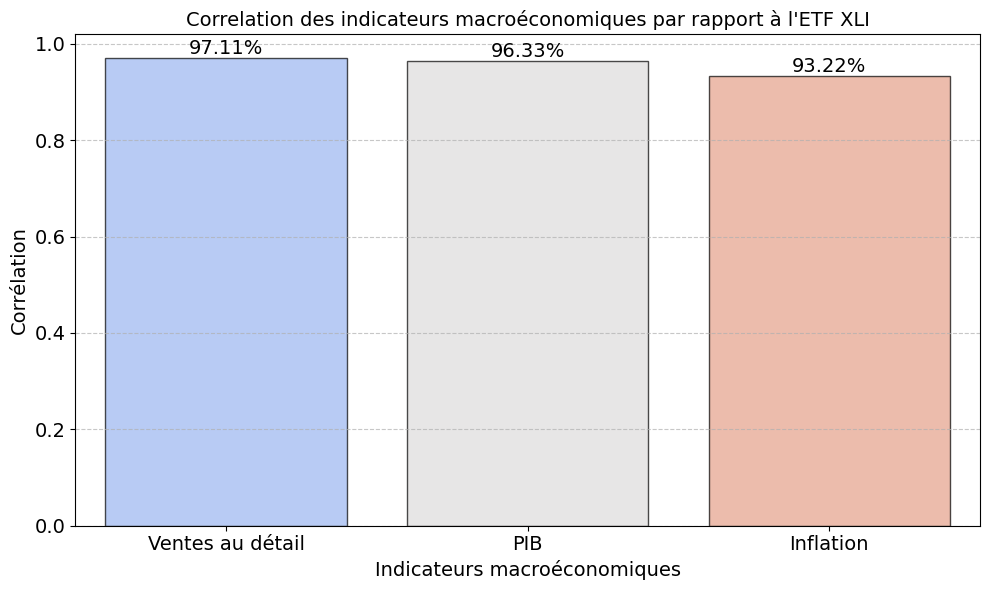

In [11]:
numeric_columns = pmi_data.select_dtypes(include='number')

correlation_matrix = numeric_columns.corrwith(pmi_data['XLI'])

plt.figure(figsize=(10, 6))
correlation_matrix.drop('XLI', inplace=True)
correlation_matrix.sort_values(ascending=False, inplace=True)

abbreviations = {
    'RSXFS': 'Ventes au détail',
    'XLI': 'XLI',
    'GDP': 'PIB',
    'CPIAUCNS': 'Inflation',
}

abbreviated_columns = [abbreviations[col] for col in correlation_matrix.index]

sns.barplot(x=abbreviated_columns, y=correlation_matrix, palette='coolwarm', edgecolor='black', alpha=0.7)
plt.title('Correlation des indicateurs macroéconomiques par rapport à l\'ETF XLI', fontsize=14)
plt.xlabel('Indicateurs macroéconomiques', fontsize=14)
plt.ylabel('Corrélation', fontsize=14)
plt.xticks(rotation=0, ha='center', fontsize=14)
plt.yticks(rotation=0, fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for index, value in enumerate(correlation_matrix):
    plt.text(index, value, f'{value*100:.2f}%', ha='center', va='bottom', fontsize=14)
plt.tight_layout()
plt.show()

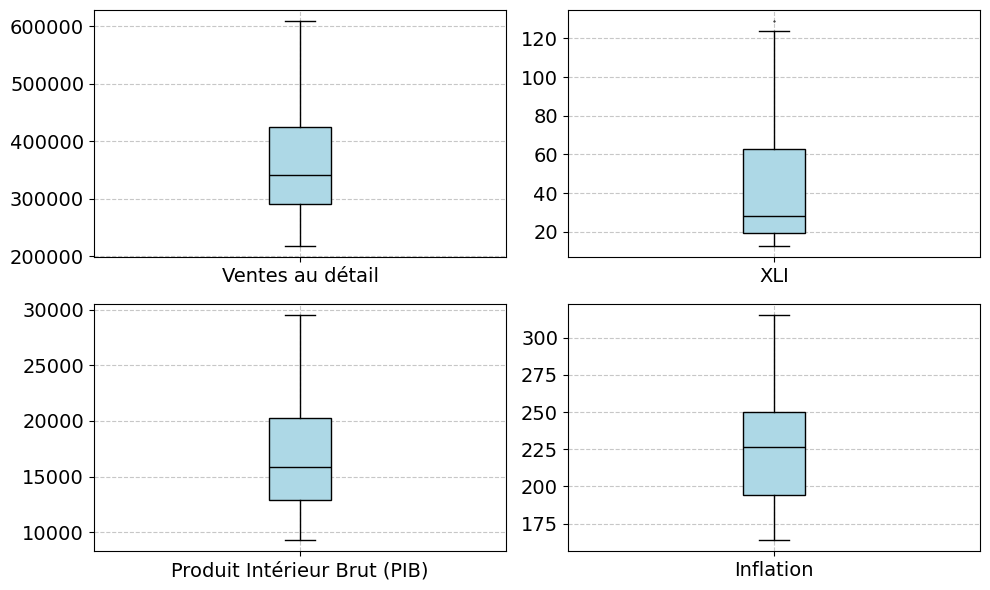

In [12]:
gdp_data = download_fred_data("GDP", "2000-01-01", "2024-12-31")
gdp_data['GDP'] = pd.to_numeric(gdp_data['GDP'], errors='coerce')
gdp_data.index = pd.to_datetime(gdp_data.index)
gdp_data.dropna()
inflation_data = download_fred_data("CPIAUCNS", "2000-01-01", "2024-12-31")
inflation_data['CPIAUCNS'] = pd.to_numeric(inflation_data['CPIAUCNS'], errors='coerce')
inflation_data.index = pd.to_datetime(inflation_data.index)


pmi_data['Date'] = pd.to_datetime(pmi_data['Date'])

plt.figure(figsize=(10, 6))

color = 'black'

scatter_size = 0.5

plt.subplot(2, 2, 1)
plt.boxplot(pmi_data['RSXFS'], boxprops=dict(color=color, facecolor='#ADD8E6'), medianprops=dict(color='black'), patch_artist=True, flierprops=dict(marker='o', markersize=scatter_size))
plt.xticks([1], ['Ventes au détail'], fontsize=14)
plt.yticks(fontsize=14)
plt.title('')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(2, 2, 2)
plt.boxplot(pmi_data['XLI'], boxprops=dict(color=color, facecolor='#ADD8E6'), medianprops=dict(color='black'), patch_artist=True, flierprops=dict(marker='o', markersize=scatter_size))
plt.xticks([1], ['XLI'], fontsize=14)
plt.title('')
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(2, 2, 3)
plt.boxplot(pmi_data['GDP'], boxprops=dict(color=color, facecolor='#ADD8E6'), medianprops=dict(color='black'), patch_artist=True, flierprops=dict(marker='o', markersize=scatter_size))
plt.xticks([1], ['Produit Intérieur Brut (PIB)'], fontsize=14)
plt.title('')
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(2, 2, 4)
plt.boxplot(pmi_data['CPIAUCNS'], boxprops=dict(color=color, facecolor='#ADD8E6'), medianprops=dict(color='black'), patch_artist=True, flierprops=dict(marker='o', markersize=scatter_size))
plt.xticks([1], ['Inflation'], fontsize=14)
plt.title('')
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

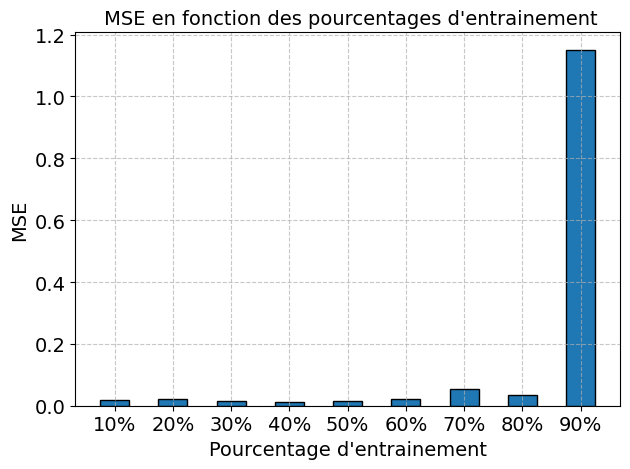

In [13]:
pmi_data.interpolate(method='linear', inplace=True)

columns_to_normalize = pmi_data.columns.difference(['Date'])

scaler = StandardScaler()

pmi_data[columns_to_normalize] = scaler.fit_transform(pmi_data[columns_to_normalize])

def prepare_data(data, look_back=6):
    X_retail_sales = []
    X_XLI = []
    X_Inflation = []
    X_GDP = []
    y_retail_sales = []
    y_XLI = []
    y_Inflation = []
    y_GDP = []

    for i in range(len(data) - look_back):
        X_row_retail_sales = []
        X_row_XLI = []
        X_row_Inflation = []
        X_row_GDP = []

        for column in ['RSXFS', 'XLI', 'CPIAUCNS', 'GDP']:
            if column == 'RSXFS':
                X_row_retail_sales.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == 'XLI':
                X_row_XLI.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == 'CPIAUCNS':
                X_row_Inflation.extend(data[column].iloc[i:i+look_back].values.flatten())
            elif column == 'GDP':
                X_row_GDP.extend(data[column].iloc[i:i+look_back].values.flatten())

        X_retail_sales.append(X_row_retail_sales)
        X_XLI.append(X_row_XLI)
        X_Inflation.append(X_row_Inflation)
        X_GDP.append(X_row_GDP)

        y_retail_sales.append(data['RSXFS'].iloc[i+look_back])
        y_XLI.append(data['XLI'].iloc[i+look_back])
        y_Inflation.append(data['CPIAUCNS'].iloc[i+look_back])
        y_GDP.append(data['GDP'].iloc[i+look_back])

    return (
        np.array(X_retail_sales), np.array(X_XLI),
        np.array(X_Inflation), np.array(X_GDP),
        np.array(y_retail_sales), np.array(y_XLI),
        np.array(y_Inflation), np.array(y_GDP)
    )

split_percentages = range(1, 10)

split_sizes = {}

best_score = float('inf')
best_split = None

errors = []

for percentage in split_percentages:
    percentage /= 10.0

    train_data, test_data = train_test_split(pmi_data, test_size=percentage, shuffle=False)

    train_size = len(train_data)
    test_size = len(test_data)
    split_sizes[percentage] = {'train_size': train_size, 'test_size': test_size}

    X_train_retail_sales, X_train_XLI, X_train_Inflation, X_train_GDP, y_train_retail_sales, y_train_XLI, y_train_Inflation, y_train_GDP = prepare_data(train_data)
    X_test_retail_sales, X_test_XLI, X_test_Inflation, X_test_GDP, y_test_retail_sales, y_test_XLI, y_test_Inflation, y_test_GDP = prepare_data(test_data)

    X_train_combined_retail_sales = np.concatenate((X_train_retail_sales, X_train_XLI, X_train_Inflation, X_train_GDP), axis=1)

    X_train_combined_XLI = np.concatenate((X_train_XLI, X_train_retail_sales, X_train_Inflation, X_train_GDP), axis=1)

    X_train_combined_Inflation = np.concatenate((X_train_Inflation, X_train_XLI, X_train_retail_sales, X_train_GDP), axis=1)

    X_train_combined_GDP = np.concatenate((X_train_GDP, X_train_XLI, X_train_retail_sales, X_train_Inflation), axis=1)

    from sklearn.linear_model import BayesianRidge

    model_XLI = BayesianRidge()
    model_XLI.fit(X_train_combined_XLI, y_train_XLI)

    model_retail_sales = BayesianRidge()
    model_retail_sales.fit(X_train_combined_retail_sales, y_train_retail_sales)

    model_Inflation = BayesianRidge()
    model_Inflation.fit(X_train_combined_Inflation, y_train_Inflation)

    model_GDP = BayesianRidge()
    model_GDP.fit(X_train_combined_GDP, y_train_GDP)

    X_test_combined_retail_sales = np.concatenate((X_test_retail_sales, X_test_XLI, X_test_Inflation, X_test_GDP), axis=1)

    X_test_combined_XLI = np.concatenate((X_test_XLI, X_test_retail_sales, X_test_Inflation, X_test_GDP), axis=1)

    X_test_combined_Inflation = np.concatenate((X_test_Inflation, X_test_XLI, X_test_retail_sales, X_test_GDP), axis=1)

    X_test_combined_GDP = np.concatenate((X_test_GDP, X_test_XLI, X_test_retail_sales, X_test_Inflation), axis=1)

    y_pred_combined_retail_sales = model_retail_sales.predict(X_test_combined_retail_sales)

    y_pred_combined_XLI = model_XLI.predict(X_test_combined_XLI)

    y_pred_combined_Inflation = model_Inflation.predict(X_test_combined_Inflation)

    y_pred_combined_GDP = model_GDP.predict(X_test_combined_GDP)

    mse_XLI = mean_squared_error(y_test_XLI, y_pred_combined_XLI)
    mse_retail_sales = mean_squared_error(y_test_retail_sales, y_pred_combined_retail_sales)
    mse_Inflation = mean_squared_error(y_test_Inflation, y_pred_combined_Inflation)
    mse_GDP = mean_squared_error(y_test_GDP, y_pred_combined_GDP)

    errors.append(mse_XLI)

    if mse_XLI < best_score:
        best_score = mse_XLI
        best_split = percentage

train_data, test_data = train_test_split(pmi_data, test_size=best_split, shuffle=False)

X_train_retail_sales, X_train_XLI, X_train_Inflation, X_train_GDP, y_train_retail_sales, y_train_XLI, y_train_Inflation, y_train_GDP = prepare_data(train_data)
X_test_retail_sales, X_test_XLI, X_test_Inflation, X_test_GDP, y_test_retail_sales, y_test_XLI, y_test_Inflation, y_test_GDP = prepare_data(test_data)

plt.bar(split_percentages, errors, width=0.5, edgecolor='black')
plt.xlabel('Pourcentage d\'entrainement', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.title(' MSE en fonction des pourcentages d\'entrainement', fontsize=14)

plt.xticks(split_percentages, [f'{int(x * 10)}%' for x in split_percentages], fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

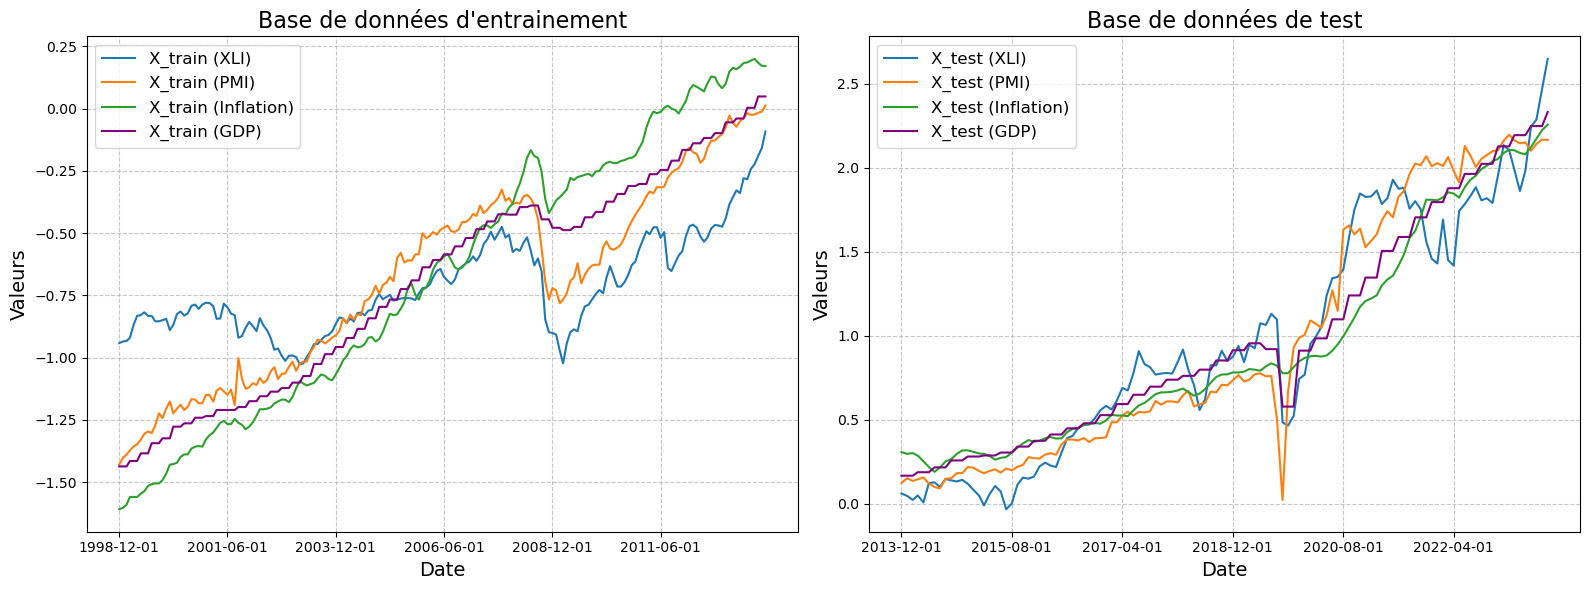

In [15]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#800080']

train_dates = pmi_data['Date'][:len(X_train_XLI)]
test_dates = pmi_data['Date'][len(X_train_XLI):len(X_train_XLI)+len(X_test_XLI)]

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(train_dates, [sample[0] for sample in X_train_XLI], color=colors[0], label='X_train (XLI)')
plt.plot(train_dates, [sample[1] for sample in X_train_retail_sales], color=colors[1], label='X_train (PMI)')
plt.plot(train_dates, [sample[1] for sample in X_train_Inflation], color=colors[2], label='X_train (Inflation)')
plt.plot(train_dates, [sample[1] for sample in X_train_GDP], color=colors[3], label='X_train (GDP)')
plt.xticks(train_dates[::30], rotation=0)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Valeurs', fontsize=14)
plt.title('Base de données d\'entrainement', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(test_dates, [sample[0] for sample in X_test_XLI], color=colors[0], label='X_test (XLI)')
plt.plot(test_dates, [sample[1] for sample in X_test_retail_sales], color=colors[1], label='X_test (PMI)')
plt.plot(test_dates, [sample[1] for sample in X_test_Inflation], color=colors[2], label='X_test (Inflation)')
plt.plot(test_dates, [sample[1] for sample in X_test_GDP], color=colors[3], label='X_test (GDP)')
plt.xticks(test_dates[::20], rotation=0)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Valeurs', fontsize=14)
plt.title('Base de données de test', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

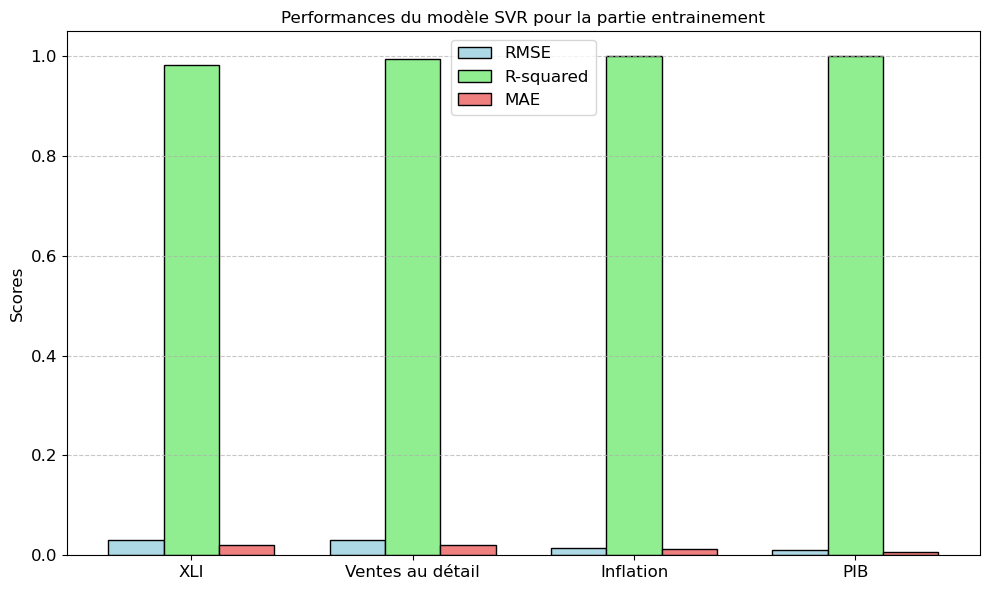

Affichage des résultats d'entrainement pour XLI:
Train RMSE (XLI): 0.029904486022606706
Train R-squared (XLI): 0.9823791134163448
Train MAE (XLI): 0.021126973280211406


Affichage des résultats d'entrainement pour retail_sales:
Train RMSE (retail_sales): 0.030914607416734945
Train R-squared (retail_sales): 0.9935358278096389
Train MAE (retail_sales): 0.021529710437466227


Affichage des résultats d'entrainement pour Inflation:
Train RMSE (Inflation): 0.015099546021848246
Train R-squared (Inflation): 0.9992300846930042
Train MAE (Inflation): 0.011883846200165011


Affichage des résultats d'entrainement pour GDP:
Train RMSE (GDP): 0.010260273506376509
Train R-squared (GDP): 0.9994290801258011
Train MAE (GDP): 0.007118142385828258


In [17]:
X_train_combined_retail_sales = np.concatenate((X_train_retail_sales, X_train_XLI, X_train_Inflation, X_train_GDP), axis=1)

X_train_combined_XLI = np.concatenate((X_train_XLI, X_train_retail_sales, X_train_Inflation, X_train_GDP), axis=1)

X_train_combined_Interest_Rate = np.concatenate((X_train_XLI, X_train_retail_sales, X_train_Inflation, X_train_GDP), axis=1)

X_train_combined_Inflation = np.concatenate((X_train_Inflation, X_train_XLI, X_train_retail_sales, X_train_GDP), axis=1)

X_train_combined_GDP = np.concatenate((X_train_GDP, X_train_XLI, X_train_retail_sales, X_train_Inflation), axis=1)

from sklearn.linear_model import BayesianRidge

model_XLI = BayesianRidge()
model_XLI.fit(X_train_combined_XLI, y_train_XLI)

model_retail_sales = BayesianRidge()
model_retail_sales.fit(X_train_combined_retail_sales, y_train_retail_sales)

model_Inflation = BayesianRidge()
model_Inflation.fit(X_train_combined_Inflation, y_train_Inflation)

model_GDP = BayesianRidge()
model_GDP.fit(X_train_combined_GDP, y_train_GDP)

y_train_pred_retail_sales = model_retail_sales.predict(X_train_combined_retail_sales)

y_train_pred_XLI = model_XLI.predict(X_train_combined_XLI)

y_train_pred_Inflation = model_Inflation.predict(X_train_combined_Inflation)

y_train_pred_GDP = model_GDP.predict(X_train_combined_GDP)

np.set_printoptions(suppress=True)

train_rmse_XLI = np.sqrt(mean_squared_error(y_train_XLI, y_train_pred_XLI))
train_r2_XLI = r2_score(y_train_XLI, y_train_pred_XLI)
train_mae_XLI = mean_absolute_error(y_train_XLI, y_train_pred_XLI)

train_rmse_retail_sales = np.sqrt(mean_squared_error(y_train_retail_sales, y_train_pred_retail_sales))
train_r2_retail_sales = r2_score(y_train_retail_sales, y_train_pred_retail_sales)
train_mae_retail_sales = mean_absolute_error(y_train_retail_sales, y_train_pred_retail_sales)

train_rmse_Inflation = np.sqrt(mean_squared_error(y_train_Inflation, y_train_pred_Inflation))
train_r2_Inflation = r2_score(y_train_Inflation, y_train_pred_Inflation)
train_mae_Inflation = mean_absolute_error(y_train_Inflation, y_train_pred_Inflation)

train_rmse_GDP = np.sqrt(mean_squared_error(y_train_GDP, y_train_pred_GDP))
train_r2_GDP = r2_score(y_train_GDP, y_train_pred_GDP)
train_mae_GDP = mean_absolute_error(y_train_GDP, y_train_pred_GDP)

models = ['XLI', 'Ventes au détail', 'Inflation', 'PIB']

rmse_scores = [train_rmse_XLI, train_rmse_retail_sales, train_rmse_Inflation, train_rmse_GDP]
r2_scores = [train_r2_XLI, train_r2_retail_sales, train_r2_Inflation, train_r2_GDP]
mae_scores = [train_mae_XLI, train_mae_retail_sales, train_mae_Inflation, train_mae_GDP]

bar_width = 0.25
index = np.arange(len(models))

plt.figure(figsize=(10, 6))

plt.bar(index - bar_width, rmse_scores, bar_width, label='RMSE', color='lightblue', edgecolor='black')

plt.bar(index, r2_scores, bar_width, label='R-squared', color='lightgreen', edgecolor='black')

plt.bar(index + bar_width, mae_scores, bar_width, label='MAE', color='lightcoral', edgecolor='black')

plt.ylabel('Scores',fontsize=12)
plt.title('Performances du modèle SVR pour la partie entrainement',fontsize=12)
plt.xticks(index, models,fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("Affichage des résultats d'entrainement pour XLI:")
print("Train RMSE (XLI):", train_rmse_XLI)
print("Train R-squared (XLI):", train_r2_XLI)
print("Train MAE (XLI):", train_mae_XLI)
print("\n")

print("Affichage des résultats d'entrainement pour retail_sales:")
print("Train RMSE (retail_sales):", train_rmse_retail_sales)
print("Train R-squared (retail_sales):", train_r2_retail_sales)
print("Train MAE (retail_sales):", train_mae_retail_sales)
print("\n")

print("Affichage des résultats d'entrainement pour Inflation:")
print("Train RMSE (Inflation):", train_rmse_Inflation)
print("Train R-squared (Inflation):", train_r2_Inflation)
print("Train MAE (Inflation):", train_mae_Inflation)
print("\n")

print("Affichage des résultats d'entrainement pour GDP:")
print("Train RMSE (GDP):", train_rmse_GDP)
print("Train R-squared (GDP):", train_r2_GDP)
print("Train MAE (GDP):", train_mae_GDP)

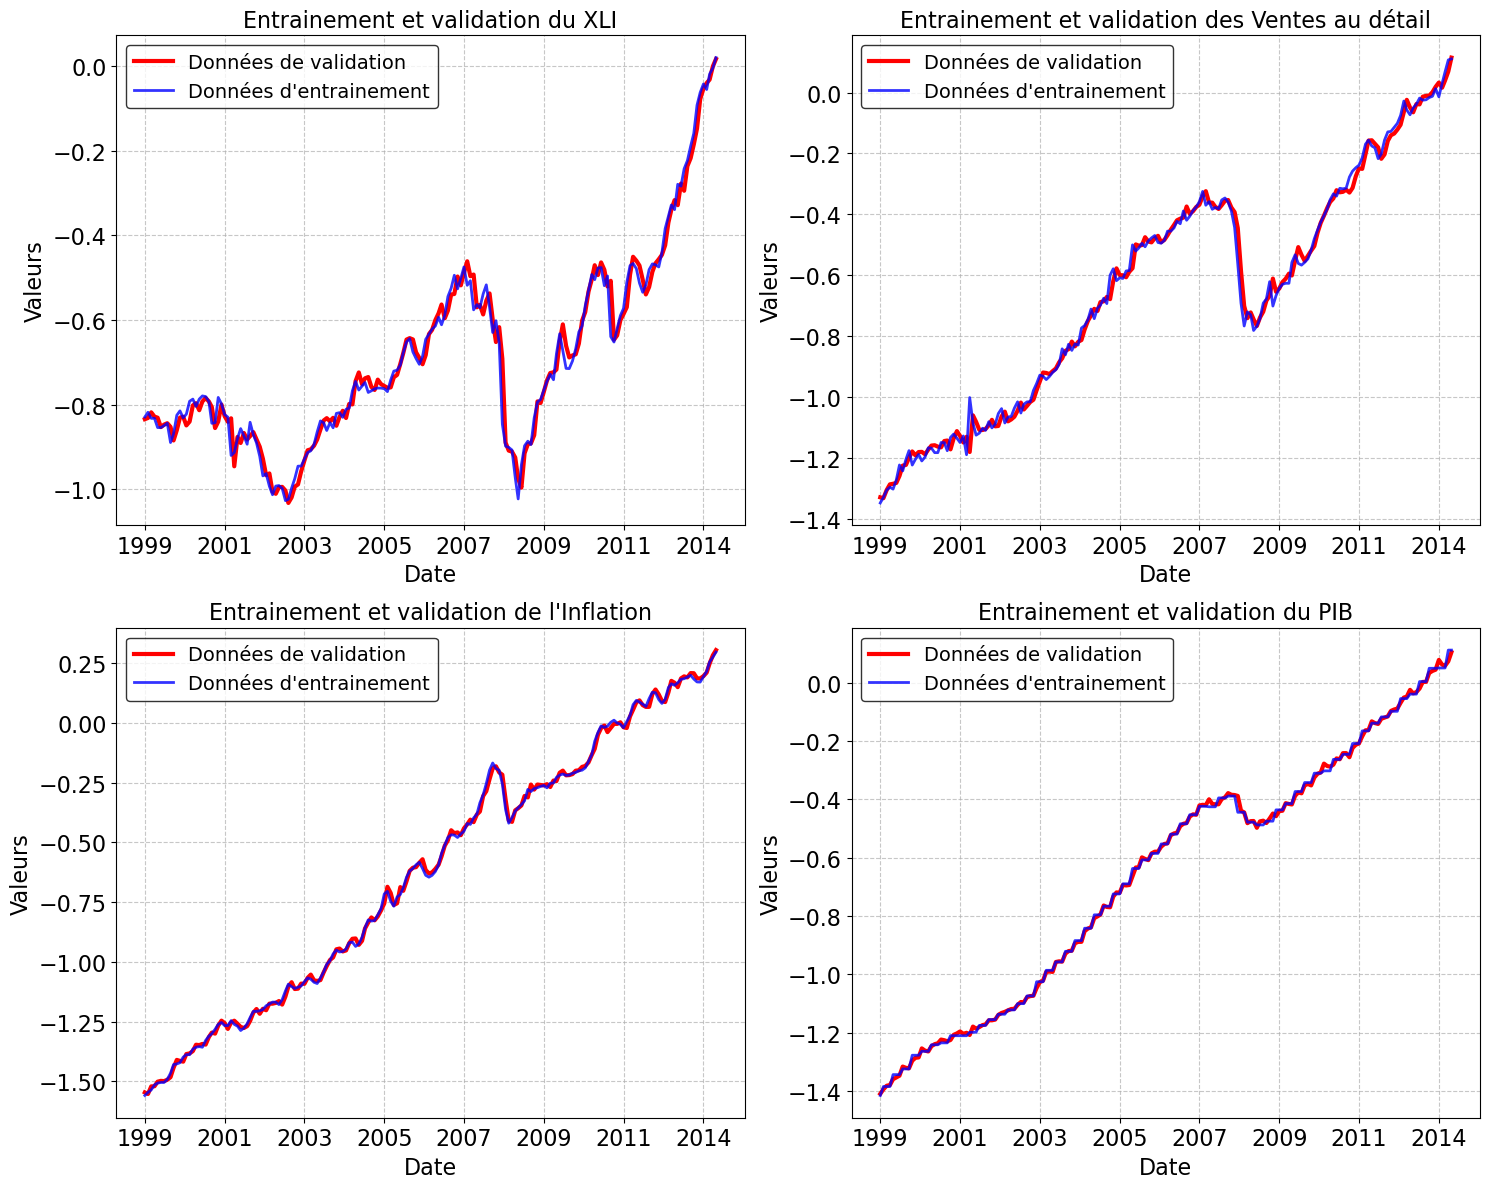

In [18]:
pmi_data_nv = pmi_data.iloc[6:]

pmi_data_nv['Date']=pd.to_datetime(pmi_data_nv['Date'])

sampled_dates = pmi_data_nv['Date'][:len(y_train_pred_XLI):len(y_train_pred_XLI)//10]
dates_train = pmi_data_nv['Date'][:len(y_train_pred_XLI)]

plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
plt.plot(dates_train, y_train_pred_XLI, label='Données de validation', color='red', linestyle='-', linewidth=3)
plt.plot(dates_train, pmi_data_nv['XLI'][:len(y_train_pred_XLI)], label='Données d\'entrainement', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Valeurs', fontsize=16)
plt.title('Entrainement et validation du XLI', fontsize=16)
plt.legend(edgecolor='black',fontsize=14)
plt.xticks(sampled_dates, rotation=0, fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=16)
sampled_dates = dates_train[::len(dates_train)//7]
ax.set_xticks(sampled_dates)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(2, 2, 2)
plt.plot(dates_train, y_train_pred_retail_sales, label='Données de validation', color='red', linestyle='-', linewidth=3)
plt.plot(dates_train, pmi_data_nv['RSXFS'][:len(y_train_pred_retail_sales)], label='Données d\'entrainement', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Valeurs', fontsize=16)
plt.title('Entrainement et validation des Ventes au détail', fontsize=16)
plt.legend(edgecolor='black',fontsize=14)
plt.xticks(sampled_dates, rotation=0, fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=10)
sampled_dates = dates_train[::len(dates_train)//7]
ax.set_xticks(sampled_dates)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(2, 2, 3)
plt.plot(dates_train, y_train_pred_Inflation, label='Données de validation', color='red', linestyle='-', linewidth=3)
plt.plot(dates_train, pmi_data_nv['CPIAUCNS'][:len(y_train_pred_Inflation)], label='Données d\'entrainement', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Valeurs', fontsize=16)
plt.title('Entrainement et validation de l\'Inflation', fontsize=16)
plt.legend(edgecolor='black',fontsize=14)
plt.xticks(sampled_dates, rotation=0, fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=10)
sampled_dates = dates_train[::len(dates_train)//7]
ax.set_xticks(sampled_dates)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(2, 2, 4)
plt.plot(dates_train, y_train_pred_GDP, label='Données de validation', color='red', linestyle='-', linewidth=3)
plt.plot(dates_train, pmi_data_nv['GDP'][:len(y_train_pred_GDP)], label='Données d\'entrainement', color='blue', markersize=3, linewidth=2, alpha=0.8)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Valeurs', fontsize=16)
plt.title('Entrainement et validation du PIB', fontsize=16)
plt.legend(edgecolor='black',fontsize=14)
plt.xticks(sampled_dates, rotation=0, fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=10)
sampled_dates = dates_train[::len(dates_train)//7]
ax.set_xticks(sampled_dates)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()

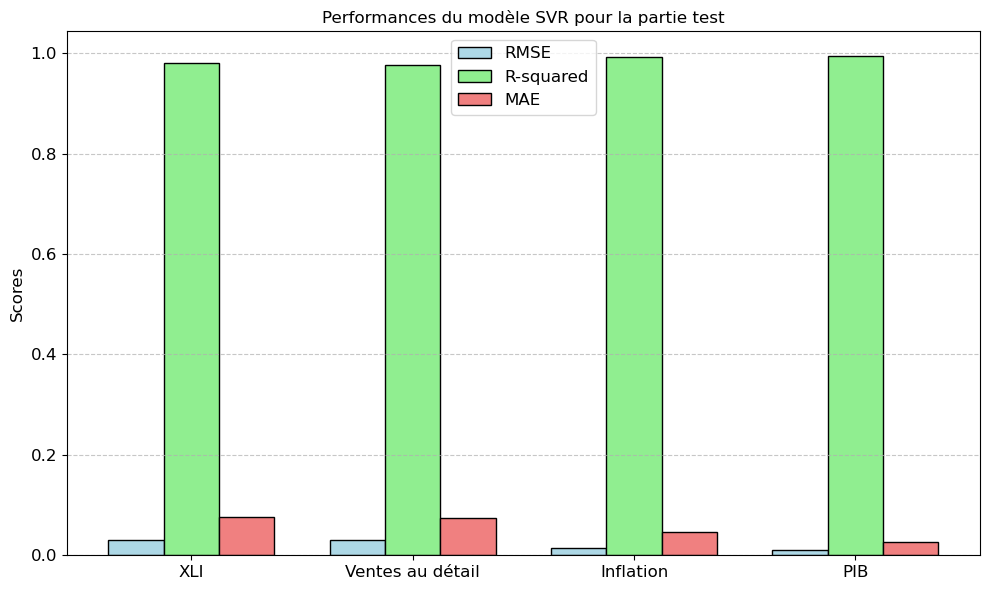

Affichage des résultats de test pour XLI:
Test RMSE (XLI): 0.012336643047810228
Test R-squared (XLI): 0.9792912974802197
Test MAE (XLI): 0.07558371202792359


Affichage des résultats de test pour retail_sales:
Test RMSE (retail_sales): 0.013458438076374228
Test R-squared (retail_sales): 0.9765315285363703
Test MAE (retail_sales): 0.07420590748128102


Affichage des résultats de test pour Inflation:
Test RMSE (Inflation): 0.003025515516117518
Test R-squared (Inflation): 0.993057030493134
Test MAE (Inflation): 0.046441375026440156


Affichage des résultats de test pour GDP:
Test RMSE (GDP): 0.0029406973973349335
Test R-squared (GDP): 0.9936280689939031
Test MAE (GDP): 0.02708757155474774


In [20]:
X_test_combined_retail_sales = np.concatenate((X_test_retail_sales, X_test_XLI, X_test_Inflation, X_test_GDP), axis=1)

X_test_combined_XLI = np.concatenate((X_test_XLI, X_test_retail_sales, X_test_Inflation, X_test_GDP), axis=1)

X_test_combined_Inflation = np.concatenate((X_test_Inflation, X_test_XLI, X_test_retail_sales, X_test_GDP), axis=1)

X_test_combined_GDP = np.concatenate((X_test_GDP, X_test_XLI, X_test_retail_sales, X_test_Inflation), axis=1)

y_pred_combined_retail_sales = model_retail_sales.predict(X_test_combined_retail_sales)

y_pred_combined_XLI = model_XLI.predict(X_test_combined_XLI)

y_pred_combined_Inflation = model_Inflation.predict(X_test_combined_Inflation)

y_pred_combined_GDP = model_GDP.predict(X_test_combined_GDP)

mse_XLI = mean_squared_error(y_test_XLI, y_pred_combined_XLI)
mae_XLI = mean_absolute_error(y_test_XLI, y_pred_combined_XLI)
r2_XLI = r2_score(y_test_XLI, y_pred_combined_XLI)

mse_retail_sales = mean_squared_error(y_test_retail_sales, y_pred_combined_retail_sales)
mae_retail_sales = mean_absolute_error(y_test_retail_sales, y_pred_combined_retail_sales)
r2_retail_sales = r2_score(y_test_retail_sales, y_pred_combined_retail_sales)

mse_Inflation = mean_squared_error(y_test_Inflation, y_pred_combined_Inflation)
mae_Inflation = mean_absolute_error(y_test_Inflation, y_pred_combined_Inflation)
r2_Inflation = r2_score(y_test_Inflation, y_pred_combined_Inflation)

mse_GDP = mean_squared_error(y_test_GDP, y_pred_combined_GDP)
mae_GDP = mean_absolute_error(y_test_GDP, y_pred_combined_GDP)
r2_GDP = r2_score(y_test_GDP, y_pred_combined_GDP)
mse_scores = [mse_XLI, mse_retail_sales, mse_Inflation, mse_GDP]
r2_scores = [r2_XLI, r2_retail_sales, r2_Inflation, r2_GDP]
mae_scores = [mae_XLI, mae_retail_sales, mae_Inflation, mae_GDP]

bar_width = 0.25
index = np.arange(len(models))

plt.figure(figsize=(10, 6))

plt.bar(index - bar_width, rmse_scores, bar_width, label='RMSE', color='lightblue', edgecolor='black')

plt.bar(index, r2_scores, bar_width, label='R-squared', color='lightgreen', edgecolor='black')

plt.bar(index + bar_width, mae_scores, bar_width, label='MAE', color='lightcoral', edgecolor='black')

plt.ylabel('Scores',fontsize=12)
plt.title('Performances du modèle SVR pour la partie test',fontsize=12)
plt.xticks(index, models,fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("Affichage des résultats de test pour XLI:")
print("Test RMSE (XLI):", mse_XLI)
print("Test R-squared (XLI):", r2_XLI)
print("Test MAE (XLI):", mae_XLI)
print("\n")

print("Affichage des résultats de test pour retail_sales:")
print("Test RMSE (retail_sales):", mse_retail_sales)
print("Test R-squared (retail_sales):", r2_retail_sales)
print("Test MAE (retail_sales):", mae_retail_sales)
print("\n")

print("Affichage des résultats de test pour Inflation:")
print("Test RMSE (Inflation):", mse_Inflation)
print("Test R-squared (Inflation):", r2_Inflation)
print("Test MAE (Inflation):", mae_Inflation)
print("\n")

print("Affichage des résultats de test pour GDP:")
print("Test RMSE (GDP):", mse_GDP)
print("Test R-squared (GDP):", r2_GDP)
print("Test MAE (GDP):", mae_GDP)

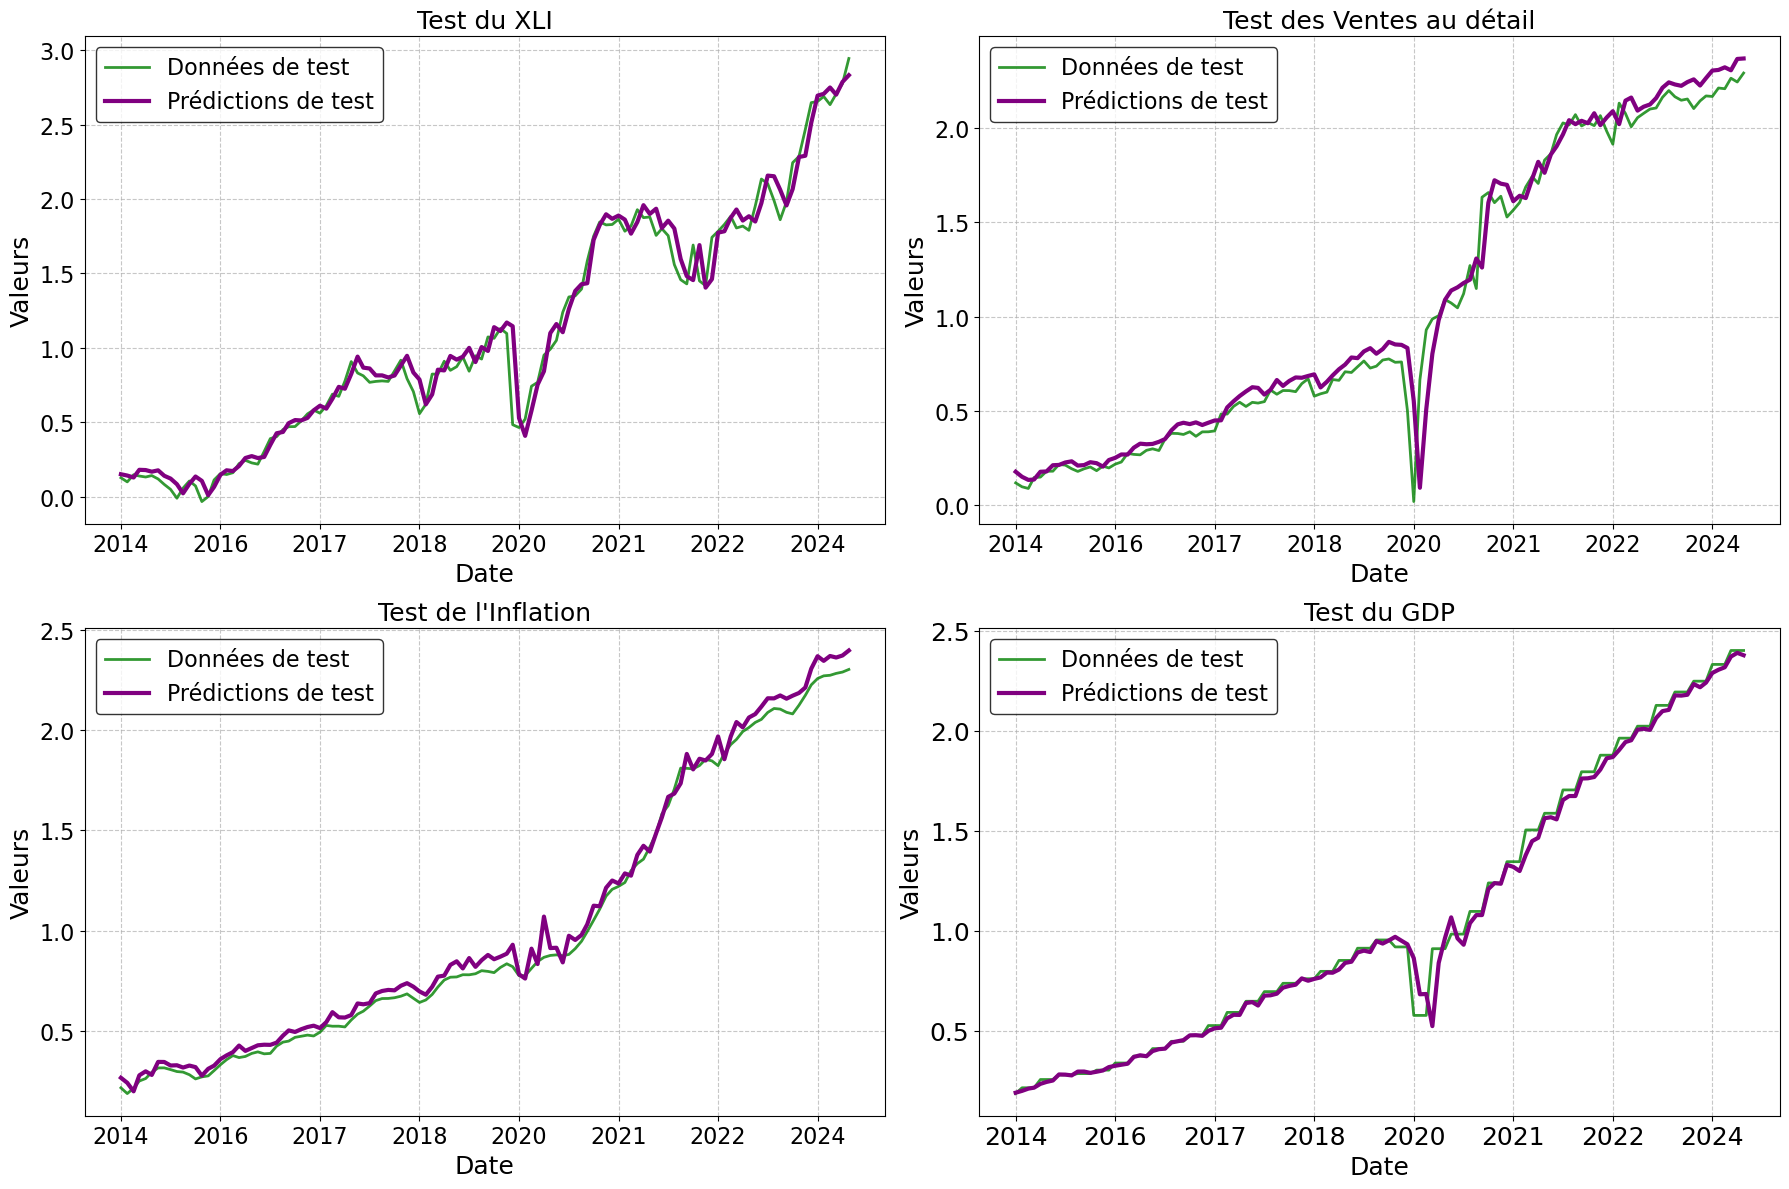

In [21]:
premiere_valeur_y_test_XLI = y_test_XLI[0]

index_premiere_occurrence_XLI = pmi_data[pmi_data['XLI'] == premiere_valeur_y_test_XLI].index[0]

pmi_data_test_XLI = pmi_data.loc[index_premiere_occurrence_XLI:, ['Date', 'XLI']]

premiere_valeur_y_test_retail_sales = y_test_retail_sales[0]

index_premiere_occurrence_retail_sales = pmi_data[pmi_data['RSXFS'] == premiere_valeur_y_test_retail_sales].index[0]

pmi_data_test_retail_sales = pmi_data.loc[index_premiere_occurrence_retail_sales:, ['Date', 'RSXFS']]

premiere_valeur_y_test_GDP = y_test_GDP[0]

index_premiere_occurrence_GDP = pmi_data[pmi_data['GDP'] == premiere_valeur_y_test_GDP].index[0]

pmi_data_test_GDP = pmi_data.loc[index_premiere_occurrence_GDP:, ['Date', 'GDP']]

premiere_valeur_y_test_Inflation = y_test_Inflation[0]

index_premiere_occurrence_Inflation = pmi_data[pmi_data['CPIAUCNS'] == premiere_valeur_y_test_Inflation].index[0]

pmi_data_test_Inflation = pmi_data.loc[index_premiere_occurrence_Inflation:, ['Date', 'CPIAUCNS']]

dates_XLI = pmi_data_test_XLI['Date']
dates_retail_sales = pmi_data_test_retail_sales['Date']
dates_GDP = pmi_data_test_GDP['Date']
dates_Inflation = pmi_data_test_Inflation['Date']

dates_GDP = dates_GDP[2:]

dates_XLI = dates_XLI.reset_index(drop=True)
dates_retail_sales = dates_retail_sales.reset_index(drop=True)
dates_GDP = dates_GDP.reset_index(drop=True)
dates_Inflation = dates_Inflation.reset_index(drop=True)

pmi_data_test_XLI = pmi_data_test_XLI.reset_index(drop=True)
pmi_data_test_retail_sales = pmi_data_test_retail_sales.reset_index(drop=True)
pmi_data_test_GDP = pmi_data_test_GDP.reset_index(drop=True)
pmi_data_test_Inflation = pmi_data_test_Inflation.reset_index(drop=True)

pmi_data_test_GDP = pmi_data_test_GDP.drop([0, 1])
pmi_data_test_GDP = pmi_data_test_GDP.reset_index(drop=True)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

ax1.plot(dates_XLI, pmi_data_test_XLI['XLI'], label='Données de test', color='green', markersize=3, linewidth=2, alpha=0.8)
ax1.plot(dates_XLI, y_pred_combined_XLI, label='Prédictions de test', color='purple', linestyle='-', linewidth=3)
ax1.set_xlabel('Date', fontsize=18)
ax1.set_ylabel('Valeurs', fontsize=18)
ax1.set_title('Test du XLI', fontsize=18)
ax1.legend(edgecolor='black',fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
sampled_dates = dates_XLI[::len(dates_XLI)//7]
ax1.set_xticks(sampled_dates)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

ax2.plot(dates_retail_sales, pmi_data_test_retail_sales['RSXFS'], label='Données de test', color='green', markersize=3, linewidth=2, alpha=0.8)
ax2.plot(dates_retail_sales, y_pred_combined_retail_sales, label='Prédictions de test', color='purple', linestyle='-', linewidth=3)
ax2.set_xlabel('Date', fontsize=18)
ax2.set_ylabel('Valeurs', fontsize=18)
ax2.set_title('Test des Ventes au détail', fontsize=18)
ax2.legend(edgecolor='black',fontsize=16)
ax2.grid(axis='x', linestyle='--', alpha=0.7)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
sampled_dates = dates_retail_sales[::len(dates_retail_sales)//7]
ax2.set_xticks(sampled_dates)
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

ax3.plot(dates_Inflation, pmi_data_test_Inflation['CPIAUCNS'], label='Données de test', color='green', markersize=3, linewidth=2, alpha=0.8)
ax3.plot(dates_Inflation, y_pred_combined_Inflation, label='Prédictions de test', color='purple', linestyle='-', linewidth=3)
ax3.set_xlabel('Date', fontsize=18)
ax3.set_ylabel('Valeurs', fontsize=18)
ax3.set_title('Test de l\'Inflation', fontsize=18)
ax3.legend(edgecolor='black',fontsize=16)
ax3.grid(axis='x', linestyle='--', alpha=0.7)
ax3.grid(axis='y', linestyle='--', alpha=0.7)
ax3.xaxis.set_major_locator(mdates.YearLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
sampled_dates = dates_Inflation[::len(dates_Inflation)//7]
ax3.set_xticks(sampled_dates)
ax3.tick_params(axis='x', labelsize=16)
ax3.tick_params(axis='y', labelsize=16)

ax4.plot(dates_GDP, pmi_data_test_GDP['GDP'], label='Données de test', color='green', markersize=3, linewidth=2, alpha=0.8)
ax4.plot(dates_GDP, y_pred_combined_GDP, label='Prédictions de test', color='purple', linestyle='-', linewidth=3)
ax4.set_xlabel('Date', fontsize=18)
ax4.set_ylabel('Valeurs', fontsize=18)
ax4.set_title('Test du GDP', fontsize=18)
ax4.legend(edgecolor='black',fontsize=16)
ax4.grid(axis='x', linestyle='--', alpha=0.7)
ax4.grid(axis='y', linestyle='--', alpha=0.7)
ax4.xaxis.set_major_locator(mdates.YearLocator())
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
sampled_dates = dates_GDP[::len(dates_GDP)//7]
ax4.set_xticks(sampled_dates)
ax4.tick_params(axis='x', labelsize=18)
ax4.tick_params(axis='y', labelsize=18)

plt.tight_layout()

plt.show()

In [27]:
def predict_future_values(model_XLI, model_retail_sales, model_Inflation, model_GDP, start_date, end_date, pmi_data):
    future_dates = pd.date_range(start=start_date, end=end_date, freq='MS')

    past_data = pmi_data.iloc[-6:]

    past_XLI = past_data['XLI'].values.tolist()
    past_retail_sales = past_data['RSXFS'].values.tolist()
    past_Inflation = past_data['CPIAUCNS'].values.tolist()
    past_GDP = past_data['GDP'].values.tolist()

    future_predictions_retail_sales = []
    future_predictions_XLI = []
    future_predictions_Inflation = []
    future_predictions_GDP = []

    for date in future_dates:
        future_pred_retail_sales = model_retail_sales.predict(np.concatenate((past_retail_sales, past_XLI, past_Inflation, past_GDP)).reshape(1, -1))
        future_pred_XLI = model_XLI.predict(np.concatenate((past_XLI, past_retail_sales, past_Inflation, past_GDP)).reshape(1, -1))
        future_pred_Inflation = model_Inflation.predict(np.concatenate((past_Inflation, past_XLI, past_retail_sales, past_GDP)).reshape(1, -1))
        future_pred_GDP = model_GDP.predict(np.concatenate((past_GDP, past_XLI, past_retail_sales, past_Inflation)).reshape(1, -1))

        future_predictions_retail_sales.append(future_pred_retail_sales[0])
        future_predictions_XLI.append(future_pred_XLI[0])
        future_predictions_Inflation.append(future_pred_Inflation[0])
        future_predictions_GDP.append(future_pred_GDP[0])

        past_XLI.pop(0)
        past_retail_sales.pop(0)
        past_Inflation.pop(0)
        past_GDP.pop(0)
        past_XLI.append(future_pred_XLI[0])
        past_retail_sales.append(future_pred_retail_sales[0])
        past_Inflation.append(future_pred_Inflation[0])
        past_GDP.append(future_pred_GDP[0])

    future_df = pd.DataFrame(index=future_dates.strftime('%Y-%m'), data={
        'Ventes au détail': future_predictions_retail_sales,
        'XLI': future_predictions_XLI,
        'PIB': future_predictions_GDP,
        'Inflation': future_predictions_Inflation,
    })

    return future_df

last_date = pmi_data['Date'].max()
last_date = pd.to_datetime(last_date)
start_date = last_date + pd.DateOffset(months=1)
start_date = start_date.strftime('%Y-%m')

end_date = pd.to_datetime('2025-02')

predicted_df = predict_future_values(model_XLI, model_retail_sales, model_Inflation, model_GDP, start_date, end_date, pmi_data)

columns_to_normalize = ['Ventes au détail', 'XLI', 'PIB', 'Inflation']

if not predicted_df.empty:
    predicted_df[columns_to_normalize] = scaler.inverse_transform(predicted_df[columns_to_normalize])

    predicted_df = predicted_df.rename(columns={
        'Ventes au détail': 'Inflation',
        'XLI': 'PIB',
        'PIB': 'Ventes au détail',
        'Inflation': 'XLI'})
else:
    print(f"Attention: Aucune prédiction générée entre {start_date} et {end_date.strftime('%Y-%m')}. Vérifiez vos dates.")

predicted_df

,Inflation,PIB,Ventes au détail,XLI
2024-10,319.087001,32694.224141,625002.414323,113.285275
2024-11,322.873958,32939.603479,624753.009324,117.615027
2024-12,326.219223,33226.161850,625861.492092,121.899602
2025-01,328.510274,33450.659271,630753.703479,125.801792
2025-02,330.855336,33581.108805,631631.813868,128.650674


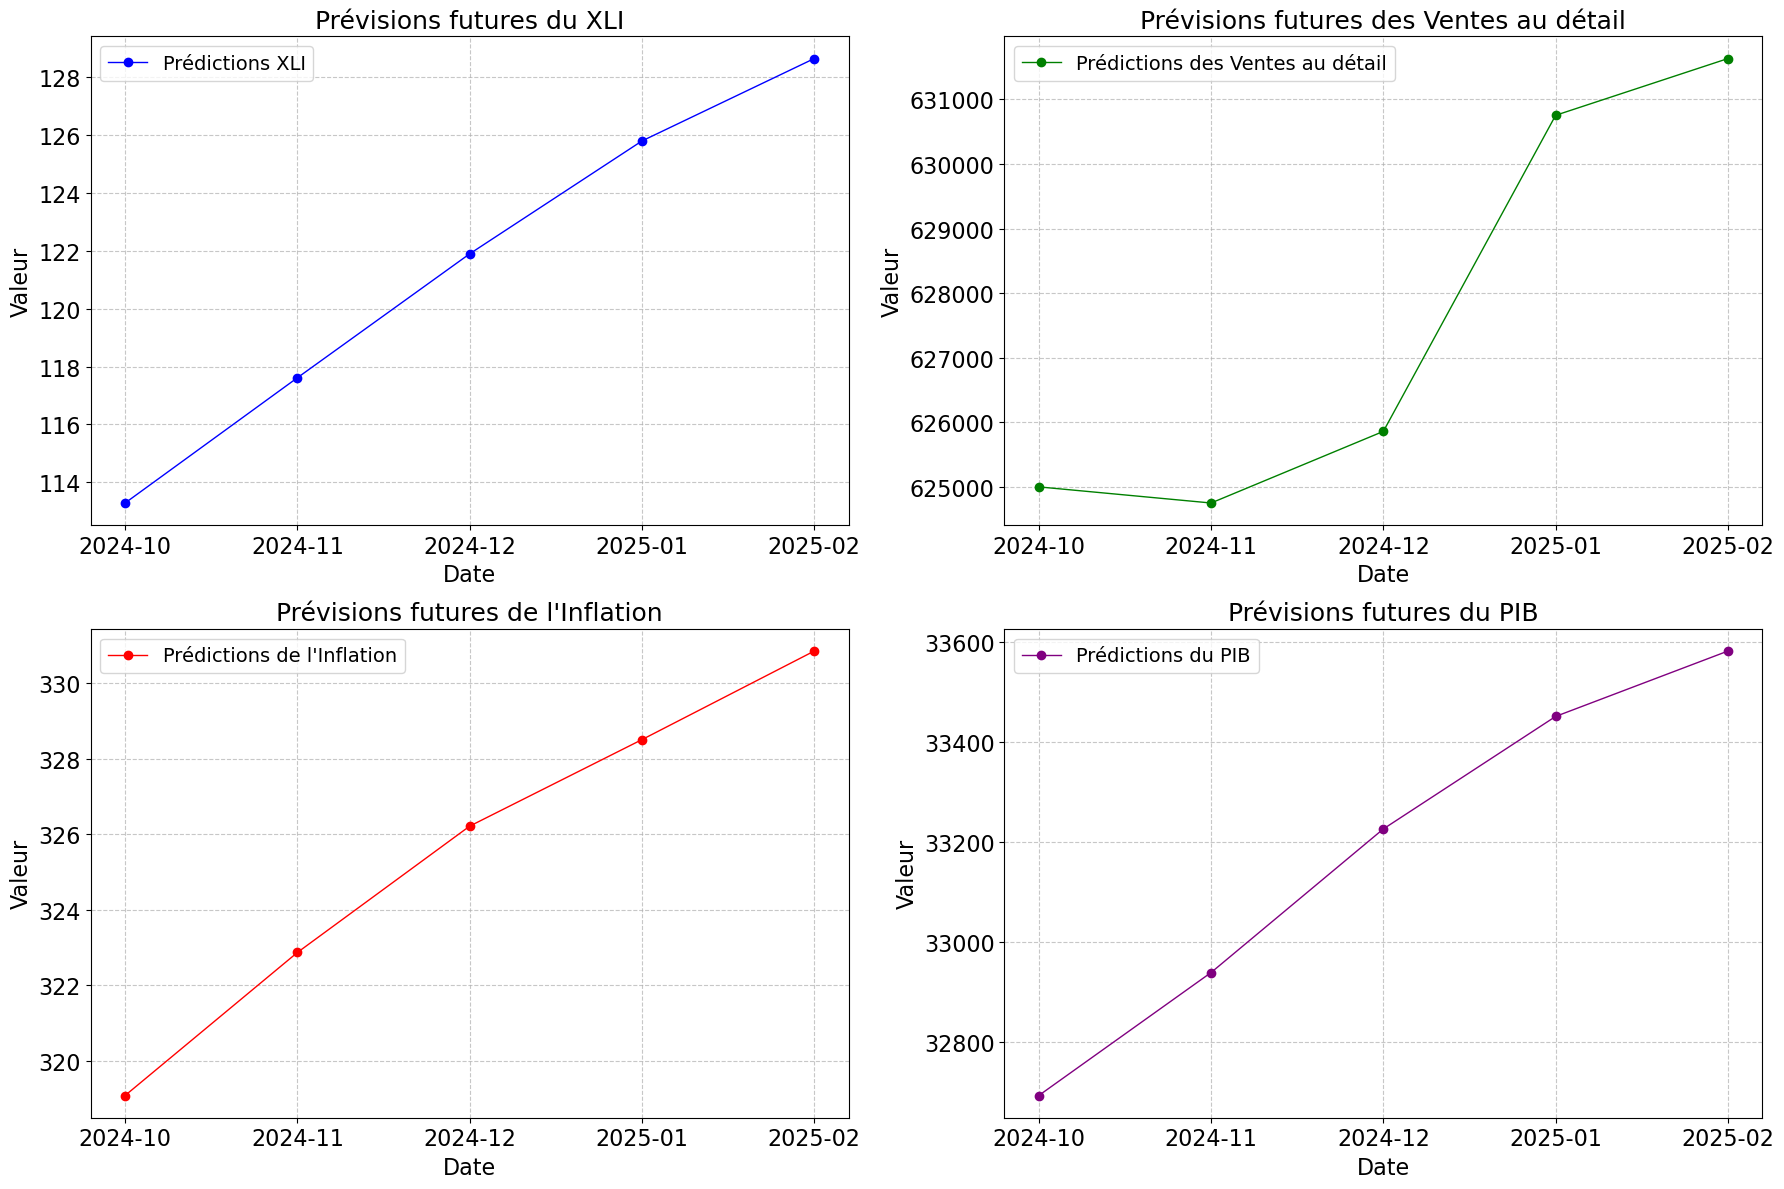

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

ax1.plot(predicted_df.index, predicted_df['XLI'], label='Prédictions XLI', color='blue', linestyle='-', marker='o', linewidth=1)
ax1.set_title('Prévisions futures du XLI', fontsize=18)
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Valeur', fontsize=16)
ax1.legend(fontsize=14)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2.plot(predicted_df.index, predicted_df['Ventes au détail'], label='Prédictions des Ventes au détail', color='green', linestyle='-', marker='o', linewidth=1)
ax2.set_title('Prévisions futures des Ventes au détail', fontsize=18)
ax2.set_xlabel('Date', fontsize=16)
ax2.set_ylabel('Valeur', fontsize=16)
ax2.legend(fontsize=14)
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax2.grid(axis='x', linestyle='--', alpha=0.7)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

ax3.plot(predicted_df.index, predicted_df['Inflation'], label='Prédictions de l\'Inflation', color='red', linestyle='-', marker='o', linewidth=1)
ax3.set_title('Prévisions futures de l\'Inflation', fontsize=18)
ax3.set_xlabel('Date', fontsize=16)
ax3.set_ylabel('Valeur', fontsize=16)
ax3.legend(fontsize=14)
ax3.tick_params(axis='x', labelsize=16)
ax3.tick_params(axis='y', labelsize=16)
ax3.grid(axis='x', linestyle='--', alpha=0.7)
ax3.grid(axis='y', linestyle='--', alpha=0.7)

ax4.plot(predicted_df.index, predicted_df['PIB'], label='Prédictions du PIB', color='purple', linestyle='-', marker='o', linewidth=1)
ax4.set_title('Prévisions futures du PIB', fontsize=18)
ax4.set_xlabel('Date', fontsize=16)
ax4.set_ylabel('Valeur', fontsize=16)
ax4.legend(fontsize=14)
ax4.tick_params(axis='x', labelsize=16)
ax4.tick_params(axis='y', labelsize=16)
ax4.grid(axis='x', linestyle='--', alpha=0.7)
ax4.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()


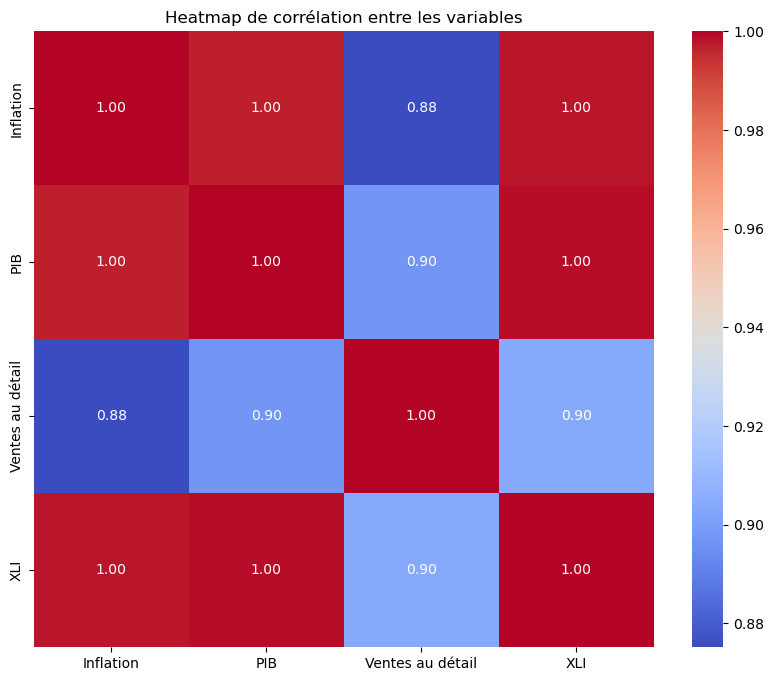

In [29]:
predicted_df.reset_index(inplace=True)
predicted_df = predicted_df.rename(columns={'index': 'Date'})

predicted_df[['Inflation', 'PIB', 'Ventes au détail', 'XLI']] = predicted_df[['Inflation', 'PIB', 'Ventes au détail', 'XLI']].astype(float)

correlation_matrix = predicted_df[['Inflation', 'PIB', 'Ventes au détail', 'XLI']].corr()

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Heatmap de corrélation entre les variables')
plt.show()